In [19]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import initializers
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [2]:
class DataFetcher:
    def __init__(self, currency, start_date, end_date):
        self.currency = currency
        self.start_date = start_date
        self.end_date = end_date

    def fetch_data(self):
        url = f"http://api.nbp.pl/api/exchangerates/rates/A/{self.currency}/{self.start_date}/{self.end_date}/"
        try:
            response = requests.get(url)
            data = response.json()
            rates = [item['mid'] for item in data['rates']]
            dates = [item['effectiveDate'] for item in data['rates']]
            return pd.DataFrame(data={'Date': dates, 'Rate': rates})
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            return pd.DataFrame()

def fetch_data_for_period(currency, start_date, end_date, delta_days=365):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    all_data = pd.DataFrame()

    while start < end:
        next_end = start + timedelta(days=delta_days)
        if next_end > end:
            next_end = end

        fetcher = DataFetcher(currency, start.strftime('%Y-%m-%d'), next_end.strftime('%Y-%m-%d'))
        data = fetcher.fetch_data()
        all_data = pd.concat([all_data, data], ignore_index=True)

        start = next_end

    return all_data

In [3]:
class DataProcessor:
    def __init__(self, dataframe, time_step=100, moving_average_window=None, num_fourier_features=None):
        self.dataframe = dataframe
        self.time_step = time_step
        self.moving_average_window=moving_average_window
        self.num_fourier_features=num_fourier_features
        if moving_average_window is not None:
            self.add_moving_average(moving_average_window)
        if num_fourier_features is not None:
            self.add_fourier_features(num_fourier_features)
    def add_moving_average(self, window_size):
        ma_column_name = f'MA_{window_size}'
        self.dataframe[ma_column_name] = self.dataframe['Rate'].rolling(window=window_size).mean()
        self.dataframe.dropna(inplace=True) 
    def add_fourier_features(self, num_features):
        fft_result = np.fft.fft(self.dataframe['Rate'].values)
        fft_freq = np.fft.fftfreq(len(fft_result))
        half_length = len(fft_freq) // 2 
        indices_high = np.argsort(-np.abs(fft_freq[:half_length]))[:num_features]  
        indices = np.concatenate((indices_high, len(fft_result) - indices_high))
        for i, idx in enumerate(indices):
            self.dataframe[f'Fourier_Real_{i}'] = np.real(fft_result[idx])
            self.dataframe[f'Fourier_Imag_{i}'] = np.imag(fft_result[idx])

        self.dataframe.dropna(inplace=True)
    def add_momentum(self, window_size):
        self.dataframe['Momentum'] = self.dataframe['Rate'].diff(periods=window_size)
        self.dataframe.dropna(inplace=True)  
    def process_data(self):
        scaler = MinMaxScaler(feature_range=(0, 1))
        columns_to_scale = ['Rate']
        if self.moving_average_window is not None:
            columns_to_scale.append(f'MA_{self.moving_average_window}')
        if hasattr(self, 'num_fourier_features'):
            for i in range(self.num_fourier_features):
                columns_to_scale.extend([f'Fourier_Real_{i}', f'Fourier_Imag_{i}'])
        if 'Momentum' in self.dataframe.columns:
            columns_to_scale.append('Momentum')
        scaled_data = scaler.fit_transform(self.dataframe[columns_to_scale])
        train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)
        return train_data, test_data, scaler
    def create_dataset(self, dataset):
        X, Y = [], []
        for i in range(len(dataset) - self.time_step):
            a = dataset[i:(i + self.time_step), 0]
            X.append(a)
            if (i + self.time_step) < len(dataset):
                Y.append(dataset[i + self.time_step, 0])
        return np.array(X), np.array(Y)

In [4]:
class RNNModel:
    def __init__(self, num_time_steps, num_features,learning_rate):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(100, return_sequences=True,  input_shape=(num_time_steps, num_features)),
            tf.keras.layers.LSTM(80, return_sequences=False ),
            tf.keras.layers.Dense(30),
            tf.keras.layers.Dense(1)
        ])
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        self.model.compile(optimizer=opt, loss='mean_squared_error')

    def train(self, X_train, y_train, batch_size, epochs):
        self.model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

    def predict(self, X_test, scaler):
        predictions = self.model.predict(X_test)
        return scaler.inverse_transform(predictions)
    def test_and_plot(self, X_test, y_test, scaler, amount=10, offset=0):
        predictions = []
        actuals = []
        input_sequences = []
        amount = min(amount, len(X_test) - offset)
        
        for i in range(offset, offset + amount):
            input_sequence = X_test[i].reshape((1, X_test.shape[1], X_test.shape[2]))
            prediction = self.model.predict(input_sequence)
            dummy_pred_array = np.zeros((prediction.shape[0], scaler.scale_.shape[0]))
            dummy_pred_array[:, 0] = prediction.ravel()
            prediction_original = scaler.inverse_transform(dummy_pred_array)[:, 0]
            dummy_y_array = np.zeros_like(dummy_pred_array)
            dummy_y_array[:, 0] = y_test[i]
            y_test_original = scaler.inverse_transform(dummy_y_array)[:, 0]
            input_sequences.append(input_sequence[0, :, 0])
            predictions.append(prediction_original[0])
            actuals.append(y_test_original[0])
        plt.figure(figsize=(15, 7))
        time_steps = list(range(offset, offset + amount))
        plt.plot(time_steps, actuals, color='black', label='Actual Values (Rate)', marker='o')
        plt.plot(time_steps, predictions, color='green', label='Predicted Values (Rate)', marker='x')
        plt.title('Test Set vs. Predictions')
        plt.xlabel('Time Step')
        plt.ylabel('Rate Value')
        plt.legend()
        plt.show()

In [5]:
df = fetch_data_for_period('CHF', '2010-01-01', '2023-12-24')


In [6]:
processor = DataProcessor(df, time_step=50, moving_average_window=30, num_fourier_features=5)
processor.add_momentum(window_size=5)  
train_data, test_data, scaler = processor.process_data()
X_train, y_train = processor.create_dataset(train_data)
X_test, y_test = processor.create_dataset(test_data)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
num_time_steps = X_train.shape[1]
num_features = X_train.shape[2]
rnn_model = RNNModel(num_time_steps, num_features,0.0001)
rnn_model.train(X_train, y_train, batch_size=16, epochs=100)

Epoch 1/100
173/173 [==============================] - 9s 12ms/step - loss: 0.0124
Epoch 2/100
173/173 [==============================] - 2s 11ms/step - loss: 6.6691e-04
Epoch 3/100
173/173 [==============================] - 2s 11ms/step - loss: 5.9575e-04
Epoch 4/100
173/173 [==============================] - 2s 12ms/step - loss: 5.8331e-04
Epoch 5/100
173/173 [==============================] - 2s 12ms/step - loss: 5.6301e-04
Epoch 6/100
173/173 [==============================] - 2s 12ms/step - loss: 5.3881e-04
Epoch 7/100
173/173 [==============================] - 2s 12ms/step - loss: 5.1568e-04
Epoch 8/100
173/173 [==============================] - 2s 11ms/step - loss: 4.9354e-04
Epoch 9/100
173/173 [==============================] - 2s 11ms/step - loss: 4.8165e-04
Epoch 10/100
173/173 [==============================] - 2s 11ms/step - loss: 4.5626e-04
Epoch 11/100
173/173 [==============================] - 2s 11ms/step - loss: 4.4450e-04
Epoch 12/100
173/173 [=======================

(652, 50, 1)
1/1 [==============================] - 0s 20ms/step


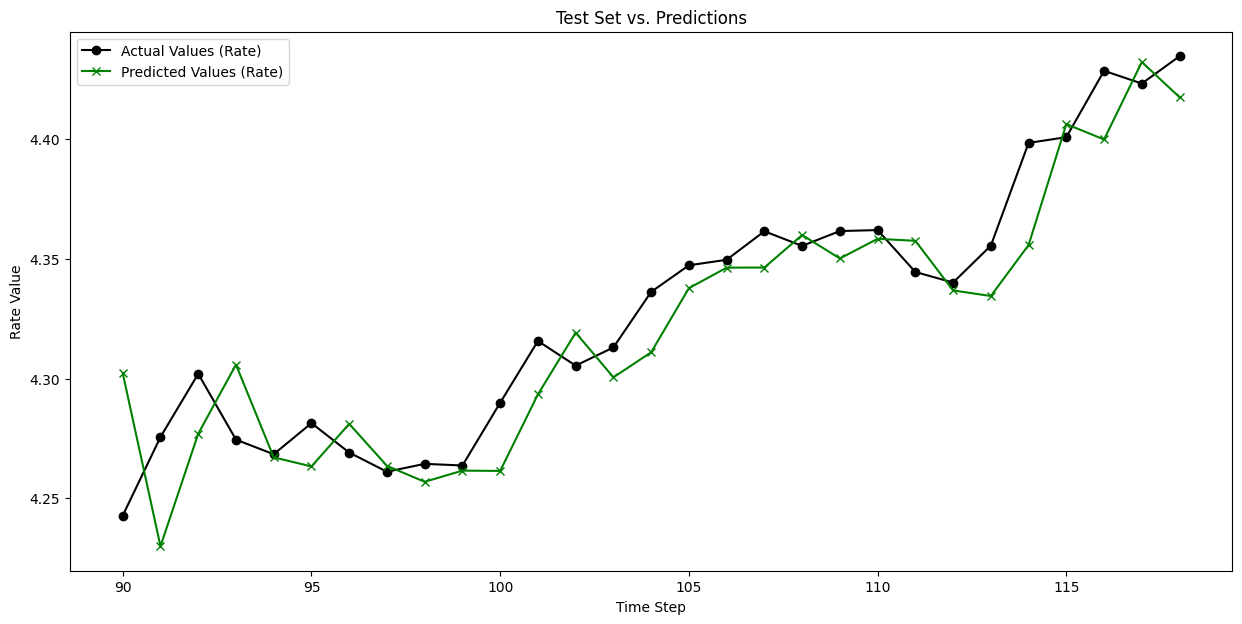

In [17]:
print(X_test.shape)
rnn_model.test_and_plot(X_test,y_test,scaler,29,90)

In [33]:
def compare_trends(actual_trends, predicted_trends):
    response_times = []
    pred_index = 0
    for actual_index in actual_trends:
        while pred_index + 1 < len(predicted_trends) and predicted_trends[pred_index] < actual_index:
            pred_index += 1
        response_times.append(predicted_trends[pred_index] - actual_index)
    return response_times
def detect_trend_changes(values, pre_trend=None):
    trend_changes = []
    trend = pre_trend  # This could be 'up', 'down', or None if not known

    for i in range(2, len(values)):
        current_trend = 'up' if values[i] > values[i-1] else 'down' if values[i] < values[i-1] else trend
        if trend and current_trend != trend:
            trend_changes.append(i-1)  # The trend changed at the previous point
        trend = current_trend  # Update the trend

    return trend_changes

# To establish the pre-trend, you look at the last few values of the training data:
last_values = y_train[-3:]  # Assuming y_train is available and has the correct format
if last_values[2] > last_values[1] > last_values[0]:
    pre_trend = 'up'
elif last_values[2] < last_values[1] < last_values[0]:
    pre_trend = 'down'
else:
    pre_trend = None  # The trend is not clear

# Now use this pre-trend when detecting trend changes in the test data
actual_trend_changes = detect_trend_changes(y_test, pre_trend=pre_trend)

# Ensure your predictions array is a flat list or 1D numpy array for this function to work correctly
predictions = np.array(predictions).flatten()
predicted_trend_changes = detect_trend_changes(predictions, pre_trend=pre_trend)


model_response_times = compare_trends(actual_trend_changes, predicted_trend_changes)

average_response_time = sum(model_response_times) / len(model_response_times)

print(f"Average model response time: {average_response_time} time steps")

# Count the frequency of each response time
response_time_counter = Counter(model_response_times)

# Find the response time with the highest frequency
most_common_response_time, frequency = response_time_counter.most_common(1)[0]

# Find the indices where this most common response time occurs
most_common_indices = [i for i, time in enumerate(model_response_times) if time == most_common_response_time]

# Find the index with the longest delay
longest_delay = max(model_response_times)
indices_with_longest_delay = [i for i, time in enumerate(model_response_times) if time == longest_delay]

print(f"The most common response time is {most_common_response_time} steps, occurring {frequency} times.")
print(f"The longest delay is {longest_delay} steps.")


Average model response time: 0.415625 time steps
The most common response time is 0 steps, occurring 182 times.
The longest delay is 1 steps.


In [31]:
predictions=np.array(predictions).flatten()
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")



Mean Squared Error: 0.00014977568302214914
Root Mean Squared Error: 0.012238287585367045
Mean Absolute Error: 0.008801101303066328
R-squared: 0.9818752311024541


rnn_model.test_and_plot(X_test, y_test, scaler,  amount=10,offset=76)
